# Pix2Pix with building facades

# Importing the Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time
import cv2

from IPython import display
from skimage.transform import resize

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()[3]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15586899500799198908
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"

In [3]:
#gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
#session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Dataset
#### Images resized to (286, 286, 3) with Nearest Neighbour and then randomly cropped to (256, 256, 3) and flipped sideways. Everything in function 'mirror'

In [4]:
IMAGE_SHAPE = (256, 256, 3)
RESIZE_SHAPE = (286, 286, 3)
BUFFER_SIZE = 400
BATCH_SIZE = 64

In [5]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image)
    
    w = tf.shape(image)[1]      # tf.convert_to_tensor
    w = w // 2

    real_image = tf.cast(image[:, :w, :], tf.float32)
    input_image = tf.cast(image[:, w:, :], tf.float32)

    return real_image, input_image

def normalize(real_image, input_image):
    real_image = (real_image - 127.5) / 127.5
    input_image = (input_image - 127.5) / 127.5
    return real_image, input_image

@tf.function
def resize(real_image, input_image, height=IMAGE_SHAPE[0], width=IMAGE_SHAPE[1]):
    real_image = tf.image.resize(real_image, [height, width],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    input_image = tf.image.resize(input_image, [height, width],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return real_image, input_image

@tf.function
def random_crop(real_image, input_image):
    stacked_image = tf.stack([real_image, input_image], axis=0)
    cropped_image = tf.image.random_crop(
          stacked_image, size=[2, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3])

    return cropped_image[0], cropped_image[1]
    '''
    real_image = tf.image.random_crop(real_image,  size=[IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3])
    input_image = tf.image.random_crop(input_image,  size=[IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3])
    return real_image, input_image
    '''
@tf.function
def preprocess(real_image, input_image):
    real_image, input_image = resize(real_image, input_image, RESIZE_SHAPE[0], RESIZE_SHAPE[1])
    real_image, input_image = random_crop(real_image, input_image)
    
    if tf.random.uniform(()) > 0.5:      # chance
        real_image = tf.image.flip_left_right(real_image)
        input_image = tf.image.flip_left_right(input_image)
    
    return real_image, input_image

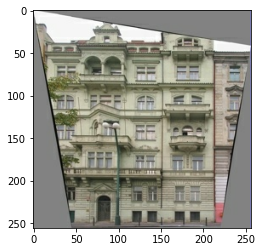

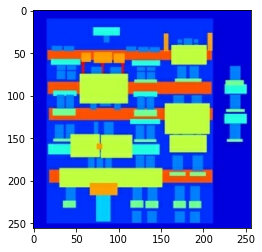

In [6]:
path = '/content/drive/My Drive/Colab Notebooks/pix2pix_facades/train/100.jpg'
re, inp = load_image(path)
plt.figure()
plt.imshow(re/255.0)
plt.figure()
plt.imshow(inp/255.0)

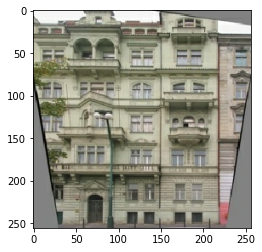

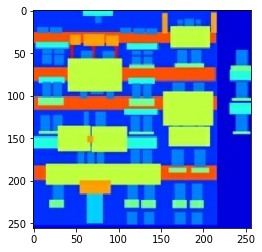

In [7]:
real_image, input_image = preprocess(re, inp)
plt.figure()
plt.imshow(real_image/255.0)
plt.figure()
plt.imshow(input_image/255.0)

# Input Pipeline

In [8]:
def load_train_image(image_path):
    input_image, real_image = load_image(image_path)
    real_image, input_image = preprocess(real_image, input_image)
    real_image, input_image = normalize(real_image, input_image)

    return real_image, input_image

def load_test_image(image_path):
    input_image, real_image = load_image(image_path)
    real_image, input_image = resize(real_image, input_image)
    real_image, input_image = normalize(real_image, input_image)

    return real_image, input_image

In [9]:
train_dataset = tf.data.Dataset.list_files('/content/drive/My Drive/Colab Notebooks/pix2pix_facades/train/*.jpg')
train_dataset = train_dataset.map(load_train_image,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files('/content/drive/My Drive/Colab Notebooks/pix2pix_facades/test/*.jpg')
test_dataset = test_dataset.map(load_test_image,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Generator
#### Each block of encoder consists of Conv2D -> BatchNorm (except the 1st block) -> LeakyReLU activation
#### Each block of decoder consists of Conv2DTranspose -> BatchNorm -> Dropout (except first 3 blocks) -> LeakyReLU activation

In [10]:
def encoder_block(model, num_filters, kernel_size=(4, 4), strides=(2, 2), apply_BN=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    model = layers.Conv2D(num_filters, kernel_size, 
                            strides=strides,
                            padding='same',
                            kernel_initializer=initializer,
                            use_bias=False)(model)

    if apply_BN:
        model = layers.BatchNormalization()(model)

    model = layers.LeakyReLU()(model)

    return model

def decoder_block(model, num_filters, kernel_size=(4, 4), strides=(2, 2), apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    model = layers.Conv2DTranspose(num_filters, kernel_size,
                                    strides=strides,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False)(model)

    model = layers.BatchNormalization()(model)

    if apply_dropout:
        model = layers.Dropout(0.5)(model)

    model = layers.LeakyReLU()(model)

    return model

In [11]:
def generator_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    encoder_1 = encoder_block(inputs, 64, (4, 4), apply_BN=False)
    encoder_2 = encoder_block(encoder_1, 128, (4, 4))
    encoder_3 = encoder_block(encoder_2, 256, (4, 4))
    encoder_4 = encoder_block(encoder_3, 512, (4, 4))
    encoder_5 = encoder_block(encoder_4, 512, (4, 4))
    encoder_6 = encoder_block(encoder_5, 512, (4, 4))
    encoder_7 = encoder_block(encoder_6, 512, (4, 4))
    encoder_8 = encoder_block(encoder_7, 512, (4, 4))

    decoder_7 = decoder_block(encoder_8, 512, (4, 4), apply_dropout=True)
    decoder_7 = layers.Concatenate()([decoder_7, encoder_7])

    decoder_6 = decoder_block(decoder_7, 512, (4, 4), apply_dropout=True)
    decoder_6 = layers.Concatenate()([decoder_6, encoder_6])

    decoder_5 = decoder_block(decoder_6, 512, (4, 4), apply_dropout=True)
    decoder_5 = layers.Concatenate()([decoder_5, encoder_5])

    decoder_4 = decoder_block(decoder_5, 512, (4, 4))
    decoder_4 = layers.Concatenate()([decoder_4, encoder_4])

    decoder_3 = decoder_block(decoder_4, 256, (4, 4))
    decoder_3 = layers.Concatenate()([decoder_3, encoder_3])

    decoder_2 = decoder_block(decoder_3, 128, (4, 4))
    decoder_2 = layers.Concatenate()([decoder_2, encoder_2])

    decoder_1 = decoder_block(decoder_2, 64, (4, 4))
    decoder_1 = layers.Concatenate()([decoder_1, encoder_1])

    out_init = tf.random_normal_initializer(0., 0.02)
    outputs = layers.Conv2DTranspose(input_shape[2], (4, 4), strides=(2, 2), padding='same',
                                    kernel_initializer=out_init, activation='tanh')(decoder_1)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Generator')
    return model

In [12]:
generator = generator_model()
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  131072      leaky_re_lu[0][0]                
__________________________________________________________________________________________

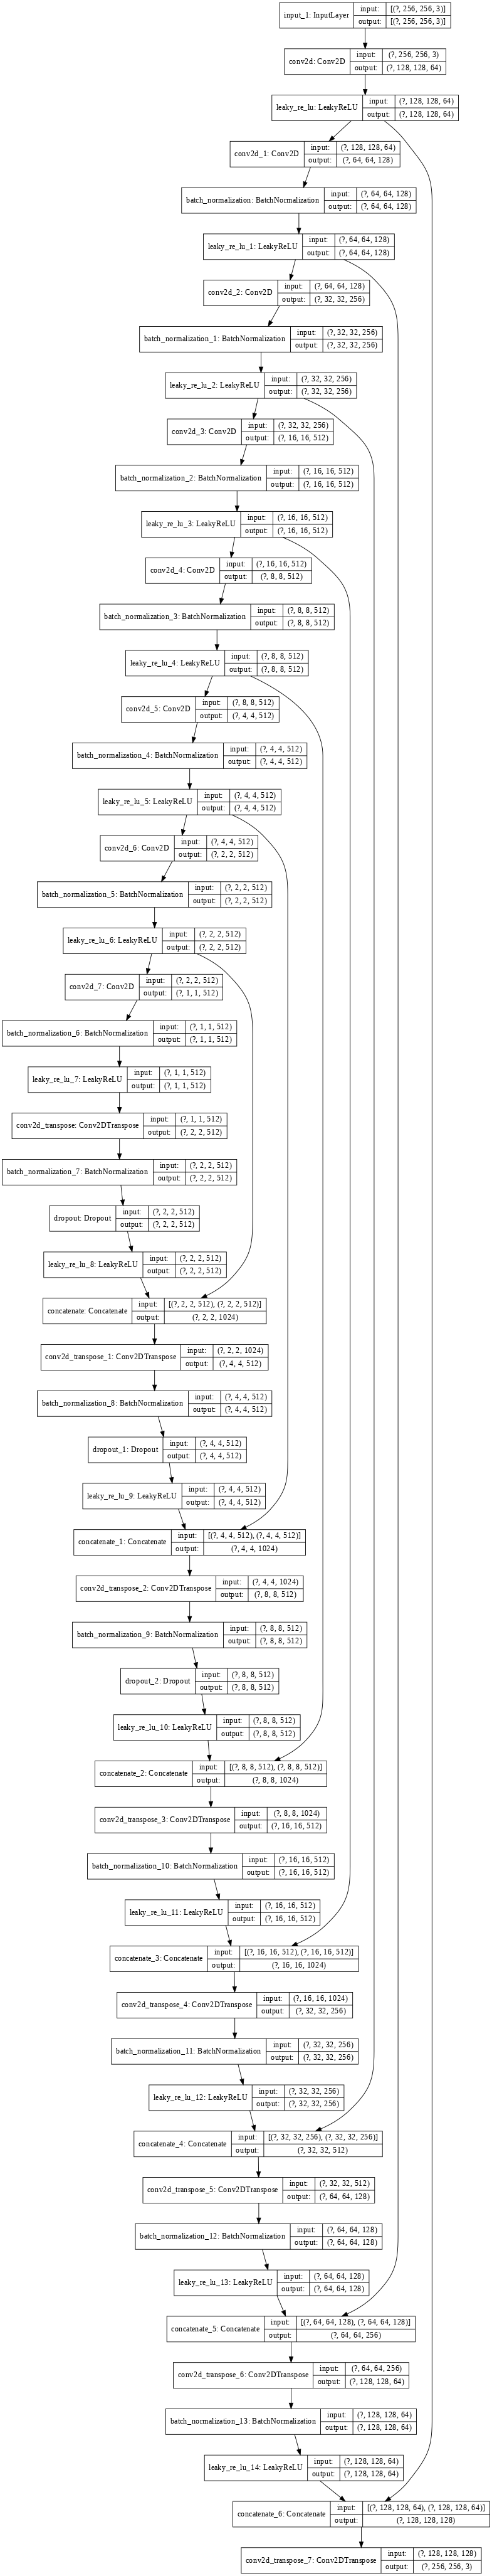

In [13]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


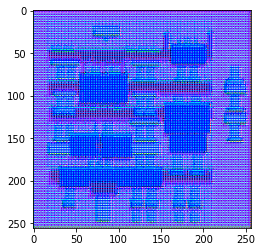

In [14]:
gen_output = generator(tf.expand_dims(inp, axis=0), training=False)
plt.imshow(gen_output[0])

# Discriminator
### PatchGAN
Each Block : Conv2D -> BatchNorm -> LeakyReLU

Output shape : (None, 30, 30, 1). Each 30x30 output classifies a 70x70 portion of input image. This 
is called PatchGAN

Discriminator takes 2 sets of inputs -> 1. Input facade and Generated image
                                        2. Input facade and the Ground Truth image from dataset

In [15]:
def discriminator_model(input_shape=(256, 256, 3)):
    initializer = tf.random_normal_initializer(0., 0.02)

    input_image = tf.keras.Input(shape=input_shape)
    target_image = tf.keras.Input(shape=input_shape)

    inputs = layers.Concatenate()([input_image, target_image])

    # Downsampling
    down_1 = encoder_block(inputs, 64, (4, 4), apply_BN=False)
    down_2 = encoder_block(down_1, 128, (4, 4))
    down_3 = encoder_block(down_2, 256, (4, 4))

    zero_pad_1 = layers.ZeroPadding2D()(down_3)

    conv = layers.Conv2D(512, (4, 4), strides=(1, 1),
                        kernel_initializer=initializer, use_bias=False)(zero_pad_1)

    batchnorm = layers.BatchNormalization()(conv)

    leakyrelu = layers.LeakyReLU()(batchnorm)

    zero_pad_2 = layers.ZeroPadding2D()(leakyrelu)

    outputs = layers.Conv2D(1, (4, 4), strides=(1, 1),
                        kernel_initializer=initializer)(zero_pad_2)

    model = tf.keras.Model(inputs=[input_image, target_image], outputs=outputs,
                        name='Discriminator')

    return model

In [16]:
discriminator = discriminator_model()
discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 64) 6144        concatenate_7[0][0]  

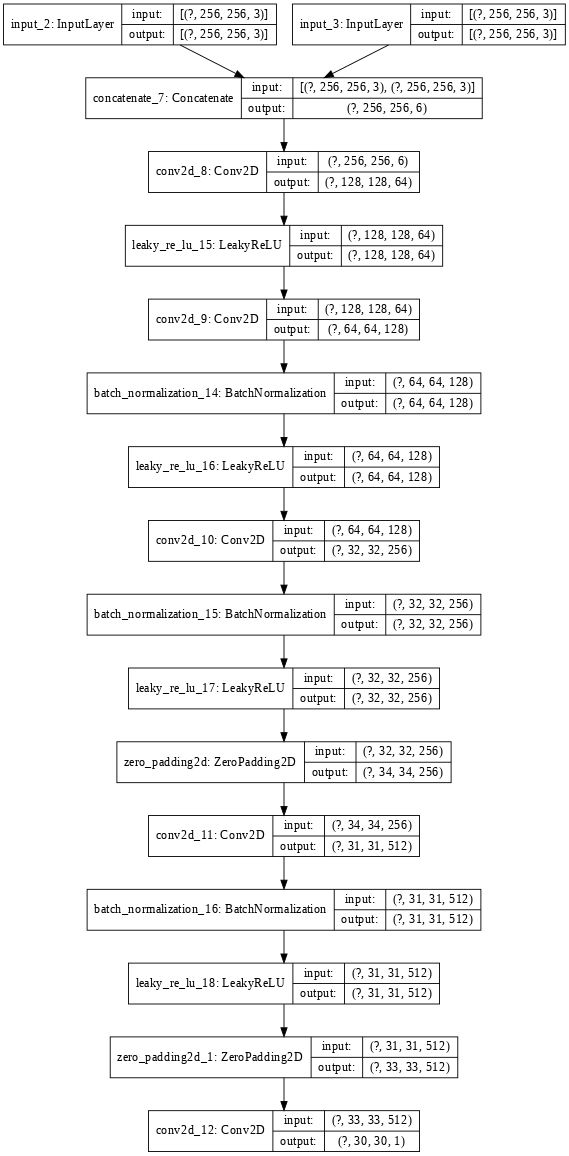

In [17]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

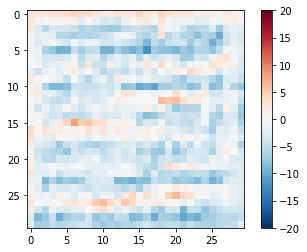

In [18]:
disc_out = discriminator([tf.expand_dims(inp, axis=0), gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

# Losses

In [19]:
LAMBDA = 100
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
# binary cross entropy between 30x30 output of discriminator from the generated image 
# MAE between generated image and target image
# Target -> real image for the facade of the building in dataset
def generator_loss(disc_generated_output, gen_output, target):
    # total_loss = gan_loss + LAMBDA * l1_loss(MAE) (value of lambda given in paper)
    gan_loss = binary_cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_generator_loss = gan_loss + LAMBDA * l1_loss
    return total_generator_loss, gan_loss, l1_loss

# Nothing new
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = binary_cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = binary_cross_entropy(tf.zeros_like(disc_generated_output),
                                        disc_generated_output)

    total_discriminator_loss = real_loss + generated_loss
    return total_discriminator_loss

# Optimizers

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Generate images (helper)

In [23]:
def generate_images(model, input_facade, target):
    prediction = model(input_facade, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [input_facade[0], target[0], prediction[0]]
    title = ['Input', 'Ground Truth', 'Prediction']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)     # images between 0 and 1
        
    plt.show()

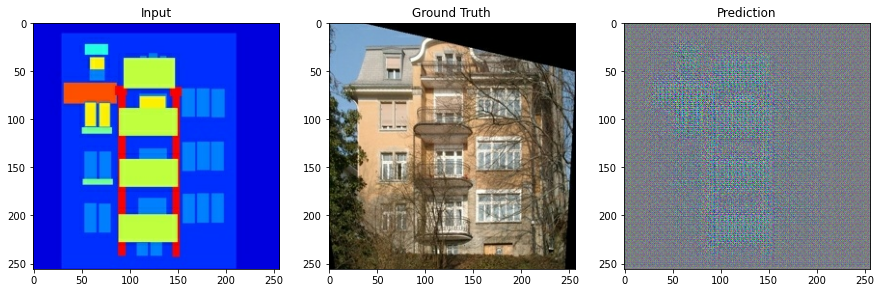

In [24]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

# Training

In [25]:
EPOCHS = 400

In [26]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_generated_output = discriminator([input_image, gen_output], training=True)
        disc_real_output = discriminator([input_image, target], training=True)

        total_generator_loss, gan_loss, l1_loss = generator_loss(disc_generated_output, gen_output, target)
        total_discriminator_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(total_generator_loss, 
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(total_discriminator_loss, 
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))


In [27]:
def train(train_dataset, test_dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        # training
        for example_input, example_target in test_dataset.take(1):
            generate_images(generator, example_input, example_target)
        print('Epoch : ', epoch + 1)

        for n, (input_image, target) in train_dataset.enumerate():
            print('.', end='')      # Loading sign lol
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target)
        print()

        # Checkpoint
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))

    checkpoint.save(file_prefix = checkpoint_prefix)    # after the last epoch

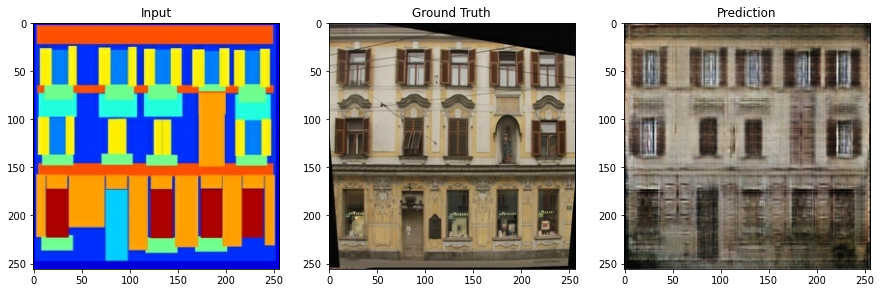

Epoch :  400
.......
Time taken for epoch 400 is 11.53805136680603 sec



In [28]:
train(train_dataset, test_dataset, EPOCHS)

In [30]:
generator.save('/content/drive/My Drive/Colab Notebooks/models/pix2pix-building-generator.h5')

# Testing

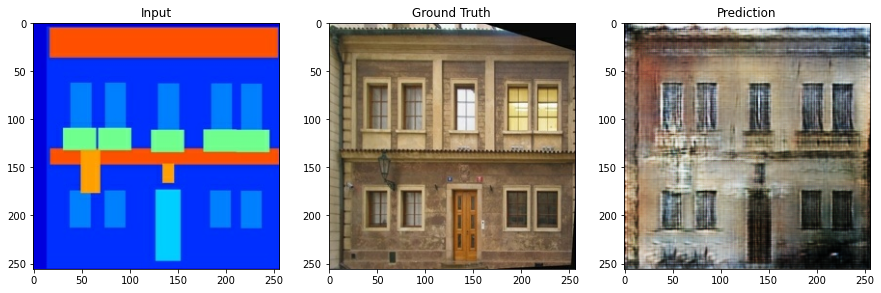

In [43]:
example_target, example_input = load_image('/content/drive/My Drive/Colab Notebooks/pix2pix_facades/val/1.jpg')
generate_images(generator, tf.expand_dims((example_input - 127.5)/127.5, 0), tf.expand_dims((example_target-127.5)/127.5, 0))